<a href="https://colab.research.google.com/github/dagyeom23658/project_dayeom_chatbot/blob/main/%EC%B1%97%EB%B4%87%EB%A7%8C%EB%93%A4%EA%B8%B0_%EC%B4%88%EA%B8%B0%EC%97%B0%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT의 문장 임베딩(SBERT)을 이용한 한국어 챗봇

- Rule-Based 모델도 가능하지만, 일단 트랜스포머를 활용해 구현해보자. 
룰베이스 예시 : https://needjarvis.tistory.com/639

- 형태소분석기 : https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=naininfo&logNo=221565581221

말뭉치란 https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=b4332&logNo=220263617191


말뭉치 데이터베이스 만드는 방법; https://aihub.or.kr/sites/default/files/2020-12/8_27%2028%2029.%EC%A4%91%EC%9D%BC%EB%B2%88%EC%97%AD%EB%A7%90%EB%AD%89%EC%B9%98_%ED%85%8C%ED%81%AC%EB%8B%88%EC%BB%AC%EB%A6%AC%ED%8F%AC%ED%8A%B8.pdf

이 작은 데이터로 형태소 분석을 해서 챗봇을 만들것이냐.
아니면 구축된 모델에 내 데이터를 얹을 것이냐.

이것 저것 다 해보는게 좋지 않나 싶다./
말뭉치모음 : 
https://ko-nlp.github.io/Korpora/ko-docs/corpuslist/korean_chatbot_data.html

형태소 분석을 하고 --> 단어 임베딩을 통해 단어유사도를 측정할 수 있다.

Sentencepiece를 활용해 Vocab 만들기
https://paul-hyun.github.io/vocab-with-sentencepiece/



허깅페이스 토커나이저 https://wikidocs.net/99893
SKT Ko-BERT의 경량화 버전 https://littlefoxdiary.tistory.com/81

파이썬 실행시간 측정 :https://opentutorials.org/module/2980/17436




In [1]:
pip install konlpy

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 86 kB 5.6 MB/s 
     |████████████████████████████████| 448 kB 35.8 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [3]:
# ! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Total 91 (delta 0), reused 0 (delta 0), pack-reused 91
Unpacking objects: 100% (91/91), done.


In [4]:
# cd Mecab-ko-for-Google-Colab

/content/Mecab-ko-for-Google-Colab


In [ ]:
# 메캅설치 시간이 좀 걸림 답답함. 런타임 재시작까지 해야댐.

In [ ]:
# ! bash install_mecab-ko_on_colab190912.sh

# 파일 불러오기

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

import re
from konlpy.tag import Okt
from tqdm import tqdm  #상태진행률 표시
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
train_data = pd.read_excel('/content/drive/MyDrive/프로젝트1/감성대화말뭉치(최종데이터)_Training.xlsx')  # 코랩에 올리고 실행되기까지 시간이 좀 걸림.
train_data.head(3)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN
2,50882,청소년,여성,학업 및 진로,해당없음,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,이 상황에서 할 수 있는 게 어떤 것이 있을까요?,중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야.,수업을 어떤 방식으로 열심히 듣는게 좋을까요?,선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해.,열심히 해서 좋은 결과가 있었으면 좋겠어요.


In [4]:
val_data = pd.read_excel('/content/drive/MyDrive/프로젝트1/감성대화말뭉치(최종데이터)_Validation.xlsx')  # 코랩에 올리고 실행되기까지 시간이 좀 걸림.
val_data.head(3)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,23093,청년,여성,"진로, 취업, 직장",해당없음,분노,툴툴대는,요즘 부모님과 많이 부딪혀.,어떤 일로 부딪히시나요?,난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔. 내 마음대로 하지도...,부모님과의 충돌로 힘드시겠군요.,응. 그래도 난 내가 하고 싶은 일을 위해 노력할 거야.,자신이 하고 싶은 일을 목표로 하기로 하셨군요.,NaN,NaN
1,32848,청소년,남성,가족관계,해당없음,슬픔,비통한,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,어머니께서 집을 나가셨다니 정말 슬프셨겠어요. 좀 더 자세히 얘기해주시겠어요?,엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어. 그래서 더 마음이 ...,정말 많이 답답하셨겠어요. 어떻게 하는 게 기분이 좀 풀릴까요?,일단 좀 자야겠어.,일단 휴식을 가질 생각이시군요.,NaN,NaN
2,35590,청소년,남성,학교폭력/따돌림,해당없음,불안,조심스러운,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,용기 있는 행동을 하셨네요. 마음이 어떠셨나요?,그런데 말을 하고 난 후 나도 괴롭힐까 봐 불안했어.,그랬군요. 지금 기분에서 벗어나기 위해 할 수 있는 일에는 무엇이 있을까요?,나는 옳은 일을 한 거라고 생각해. 나까지 괴롭힌다면 신고할 거야.,지금의 상황이 나의 방식으로써 잘 해결될 수 있기를 바라요.,NaN,NaN


In [ ]:
train_data.isnull().sum()

In [ ]:
train_data.columns

Index(['번호', '연령', '성별', '상황키워드', '신체질환', '감정_대분류', '감정_소분류', '사람문장1',
       '시스템응답1', '사람문장2', '시스템응답2', '사람문장3', '시스템응답3', '사람문장4', '시스템응답4'],
      dtype='object')

In [ ]:
train_data.dtypes

번호         int64
연령        object
성별        object
상황키워드     object
신체질환      object
감정_대분류    object
감정_소분류    object
사람문장1     object
시스템응답1    object
사람문장2     object
시스템응답2    object
사람문장3     object
시스템응답3    object
사람문장4     object
시스템응답4    object
dtype: object

### 불용어 리스트 만들기

- . 불용어는 정의하기 나름인데, 한국어의 조사, 접속사 등의 보편적인 불용어를 사용할 수도 있겠지만 결국 풀고자 하는 문제의 데이터를 지속 검토하면서 계속해서 추가하는 경우 또한 많습니다

In [5]:
stop_words1 = pd.read_excel('/content/drive/MyDrive/프로젝트1/ko_stop_words.xlsx',header=None) 
stop_words1.head()

,0,1,2
0,아,어찌됏든,하기보다는
1,휴,그위에,차라리
2,아이구,게다가,하는 편이 낫다
3,아이쿠,점에서 보아,흐흐
4,아이고,비추어 보아,놀라다


In [6]:
stop_words2 = pd.read_excel('/content/drive/MyDrive/프로젝트1/ko_stop_words2.xlsx', header=None)  # 코랩에 올리고 실행되기까지 시간이 좀 걸림.
stop_words2.head()

,0,1,2
0,이,VCP,0.018280
1,있,VA,0.011699
2,하,VV,0.009774
3,것,NNB,0.009733
4,들,XSN,0.006898


In [7]:
print(stop_words1.shape)
print(stop_words1.isna().sum())

stop1 = stop_words1.iloc[:,0].to_frame().values.tolist()
stop2 = stop_words1.iloc[:,1].to_frame().values.tolist()
stop3 = stop_words1.iloc[:,2].to_frame().dropna().values.tolist()

# 2차원리스트 -> 1차원리스트로 변환 https://codechacha.com/ko/python-flatten-list/

stop = stop1+stop2+stop3
print(len(stop))

stop2=sum(stop,[])
print(len(stop2))

stop_im = stop_words2[0].to_list()
stop_word=stop2 + stop_im
print(len(stop_word))

stop_words=set(stop_word)
print(stop_words)

(250, 3)
0     0
1     0
2    73
dtype: int64
677
677
777
{'반대로 말하자면', '육', '가령', '야', '훨씬', '기타', '하지마', '그런데', '일단', '이 되다', '할 지경이다', '비록', '이럴정도로', '꽈당', '함께', '매번', '정도', '이지만', '상대적으로 말하자면', '일지라도', '이렇구나', '예를 들자면', '대하', '어느것', '만 못하다', '우에 종합한것과같이', '우리들', '그렇', '이쪽', '얼마나', '의해서', '그리고', '하는 김에', '않', '이봐', '그렇지않으면', '도착하다', '중에서', '비추어 보아', '하물며', '더군다나', '아니나다를가', '생각하', '얼마든지', '그래도', '엉엉', '즉', '따위', '말', '되', '까지도', '일때', '여보시오', '저쪽', '때가 되어', '이만큼', '시키', '바꾸어서 한다면', '든간에', '줄은모른다', '개', '타인', '전자', '기대여', '그저', '누가 알겠는가', '토하다', '그럼에도 불구하고', '제각기', '당장', '어', '심지어', '만일', '습니까', '바와같이', '자마자', '년', '다섯', '내', '따라', '너', '데', '할 따름이다', '잠시', '그러니', '불구하고', '을', '지든지', '답다', '이로 인하여', '이천육', '통하', '이젠', '때문', '언제', '제외하고', '그렇지 않으면', '흥', '허걱', '수', '라 해도', '때', '그런 까닭에', '씨', '무엇때문에', '기준으로', '하게하다', '바꾸어말하자면', '예', '모르', '어찌하든지', '끙끙', '이상', '외에도', '얼마큼', '결론을 낼 수 있다', '퉤', '해야한다', '주', '그러나', '의해되다', '약간', '일곱', '와아', '한켠으로는', '그러', '모', '그러면', '아무거나', '시작하여', '하지 않도

In [8]:
stop_words.add(',')
stop_words.add('.')

# 감성 분류
- 일반적인 딥러닝 통해서도 가능하다. (다층퍼셉트론)
- 피드포워드신경망 https://wikidocs.net/45609

```
import time
start = time.time()  # 시작 시간 저장
 
# 작업 코드
 
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간
```


### 데이터에 대한 이해

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [10]:
print('훈련용 샘플의 개수 : {}'.format(train_data.shape))
print('검증용 샘플의 개수 : {}'.format(val_data.shape))

훈련용 샘플의 개수 : (40879, 15)
검증용 샘플의 개수 : (5130, 15)


In [ ]:
print('총 주제의 개수 : {}'.format(len(train_data['감정_대분류'].unique())))
print(train_data['감정_대분류'].unique())

# 띄워쓰기가 있구나... 전처리가 필요하구나...

총 주제의 개수 : 8
['기쁨' '불안' '당황' '슬픔' '분노' '상처' '불안 ' '기쁨 ']


In [11]:
train_data['번호']=train_data['번호'].astype('str')

In [ ]:
train_data.dtypes

번호        object
연령        object
성별        object
상황키워드     object
신체질환      object
감정_대분류    object
감정_소분류    object
사람문장1     object
시스템응답1    object
사람문장2     object
시스템응답2    object
사람문장3     object
시스템응답3    object
사람문장4     object
시스템응답4    object
dtype: object

In [12]:
# 앞뒤 공백 처리.
train_data =train_data.apply(lambda x: x.str.strip() , axis = 1)  #https://www.delftstack.com/ko/howto/python-pandas/difference-between-pandas-apply-map-and-applymap/
train_data.head(3)

# strip()이 숫자는 Nan값으로 반환해버린다...??뭐지?
# df.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)


,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN
2,50882,청소년,여성,학업 및 진로,해당없음,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,이 상황에서 할 수 있는 게 어떤 것이 있을까요?,중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야.,수업을 어떤 방식으로 열심히 듣는게 좋을까요?,선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해.,열심히 해서 좋은 결과가 있었으면 좋겠어요.


In [13]:
print('총 감정_대분류의 개수 : {}'.format(len(train_data['감정_대분류'].unique())))
print(train_data['감정_대분류'].unique())

총 감정_대분류의 개수 : 6
['기쁨' '불안' '당황' '슬픔' '분노' '상처']


In [ ]:
print('총 감정_소분류의 개수 : {}'.format(len(train_data['감정_소분류'].unique())))
print(train_data['감정_소분류'].unique())

총 주제의 개수 : 58
['신이 난' '스트레스 받는' '당황' '안도' '취약한' '우울한' '구역질 나는' '좌절한' '눈물이 나는' '배신당한'
 '남의 시선을 의식하는' '죄책감의' '당혹스러운' '분노' '두려운' '낙담한' '회의적인' '마비된' '혼란스러운' '흥분'
 '한심한' '염세적인' '안달하는' '걱정스러운' '조심스러운' '충격 받은' '상처' '불안' '노여워하는' '기쁨' '짜증내는'
 '환멸을 느끼는' '비통한' '혐오스러운' '억울한' '만족스러운' '부끄러운' '버려진' '고립된' '괴로워하는' '자신하는'
 '외로운' '방어적인' '편안한' '질투하는' '감사하는' '초조한' '실망한' '슬픔' '신뢰하는' '가난한, 불우한'
 '후회되는' '툴툴대는' '성가신' '열등감' '희생된' '느긋' '악의적인']


### 감성 레이블 만들기(숫자로 매핑)

In [14]:
#감정 대분류와 소분류를 키값쌍으로 정렬.
dic = {}
for uni_class in train_data['감정_대분류'].unique():
    uni = train_data[train_data['감정_대분류'] == uni_class]['감정_소분류'].unique()
    dic[uni_class] = list(uni)
print(dic['기쁨'])

['신이 난', '안도', '흥분', '기쁨', '만족스러운', '자신하는', '편안한', '감사하는', '신뢰하는', '느긋']


In [15]:
# 감정소분류주제 58개를 숫자레이블 딕셔너리로 변경
feel_class = train_data['감정_소분류'].unique()

i = 0
feel_dic = {}
for feel in feel_class:
    feel_dic[feel] = i
    i+=1
# feel_dic  #key:value = 감정소분류:숫자

In [ ]:
# 숫자로 감정을 찾을 수 있도록 reverse
feel_dic_reverse = {}
for key, value in feel_dic.items():
    feel_dic_reverse[value] = key
feel_dic_reverse

In [ ]:
feel_df = train_data[['감정_소분류','사람문장1']]
feel_df

,감정_소분류,사람문장1
0,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.
1,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.
2,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.
3,신이 난,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.
4,안도,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.
...,...,...
40874,혼란스러운,같이 사는 친구가 애완견을 데려왔는데 대부분 내가 돌보고 있어. 내가 주인인가 혼란...
40875,안도,지난주에 건강검진 결과가 나왔는데 정상이라고 결과가 나왔어.
40876,우울한,엄마는 내 꿈인 작가를 응원해 주고는 했는데 지금은 안 그래. 너무 슬퍼.
40877,감사하는,이렇게 좋은 운동 시설에서 경로 우대로 운동할 수 있다니 참 행운이야.


In [ ]:
li = []
for feel in feel_df['감정_소분류']:
    li.append(feel_dic[feel])
feel_df['소분류_num'] = li
feel_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,감정_소분류,사람문장1,소분류_num
0,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,0
1,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,1
2,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,2
3,신이 난,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,0
4,안도,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,3
...,...,...,...
40874,혼란스러운,같이 사는 친구가 애완견을 데려왔는데 대부분 내가 돌보고 있어. 내가 주인인가 혼란...,18
40875,안도,지난주에 건강검진 결과가 나왔는데 정상이라고 결과가 나왔어.,3
40876,우울한,엄마는 내 꿈인 작가를 응원해 주고는 했는데 지금은 안 그래. 너무 슬퍼.,5
40877,감사하는,이렇게 좋은 운동 시설에서 경로 우대로 운동할 수 있다니 참 행운이야.,45


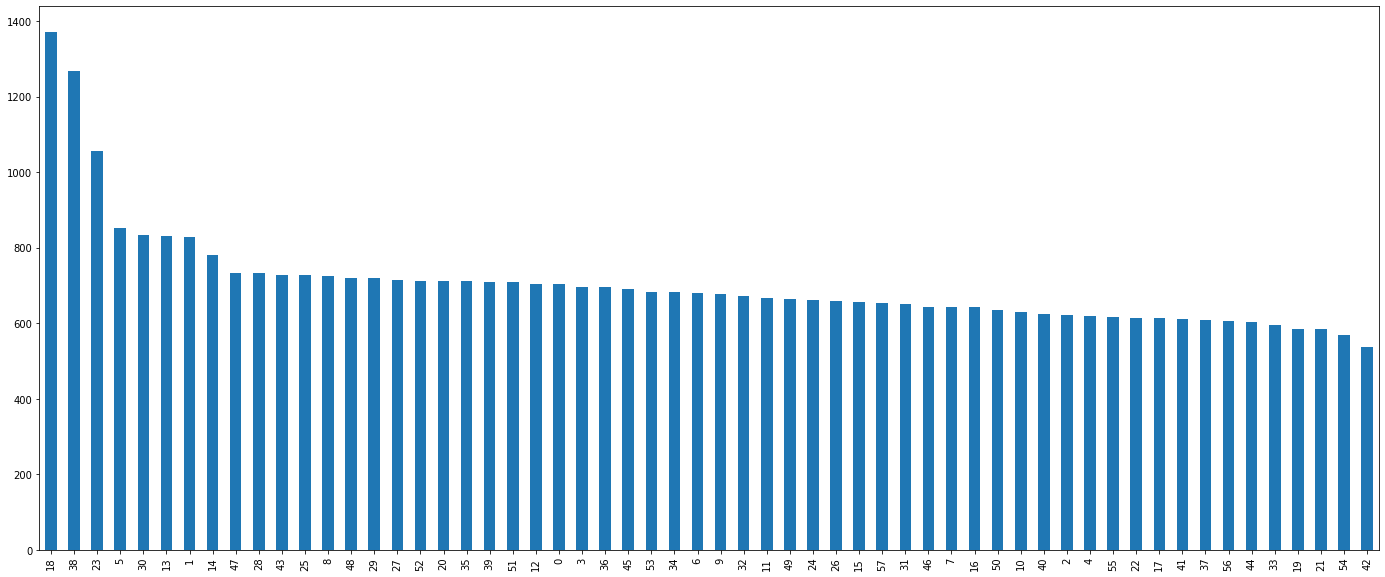

In [ ]:
# 레이블 값의 분포 시각화
plt.figure(figsize=(24, 10))
feel_df['소분류_num'].value_counts().plot(kind='bar');

In [ ]:
# 18, 38, 23번 감정이 매우 많은 분포
print('가장많은 분포의 감정: ', feel_dic_reverse[18])
print('감정분포 2위: ', feel_dic_reverse[38])
print('감정분포 3위: ',feel_dic_reverse[23])
print('감정분포 가장적은: ',feel_dic_reverse[42])

# 대체적으로 600~800개의 분포를 보인다.
# 어휴 격자 저거 y축 세분화하고싶은데 어렵네..


가장많은 분포의 감정:  혼란스러운
감정분포 2위:  고립된
감정분포 3위:  걱정스러운
감정분포 가장적은:  방어적인


In [ ]:
# 각 레이블이 몇개인가
print(feel_df.groupby('소분류_num').size().reset_index(name='count'))   #https://www.codeit.kr/community/threads/6279

#### 감성분류 정확도때문에, 대분류로 다시 만들어본다.


In [16]:
# 감정소분류주제 58개를 숫자레이블 딕셔너리로 변경
feel_bic_class = train_data['감정_대분류'].unique()

i = 0
feel_bic_dic= {}
for feel in feel_bic_class:
    feel_bic_dic[feel] = i
    i+=1
# feel_dic  #key:value = 감정소분류:숫자

In [17]:
# 숫자로 감정을 찾을 수 있도록 reverse
feel_bic_dic_reverse = {}
for key, value in feel_bic_dic.items():
    feel_bic_dic_reverse[value] = key
feel_bic_dic_reverse

{0: '기쁨', 1: '불안', 2: '당황', 3: '슬픔', 4: '분노', 5: '상처'}

In [18]:
feel_bic_df = train_data[['감정_대분류','사람문장1']]
feel_bic_df

,감정_대분류,사람문장1
0,기쁨,아내가 드디어 출산하게 되어서 정말 신이 나.
1,불안,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.
2,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.
3,기쁨,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.
4,기쁨,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.
...,...,...
40874,불안,같이 사는 친구가 애완견을 데려왔는데 대부분 내가 돌보고 있어. 내가 주인인가 혼란...
40875,기쁨,지난주에 건강검진 결과가 나왔는데 정상이라고 결과가 나왔어.
40876,슬픔,엄마는 내 꿈인 작가를 응원해 주고는 했는데 지금은 안 그래. 너무 슬퍼.
40877,기쁨,이렇게 좋은 운동 시설에서 경로 우대로 운동할 수 있다니 참 행운이야.


In [19]:
li = []
for feel in feel_bic_df['감정_대분류']:
    li.append(feel_bic_dic[feel])
feel_bic_df['대분류_num'] = li
feel_bic_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,감정_대분류,사람문장1,대분류_num
0,기쁨,아내가 드디어 출산하게 되어서 정말 신이 나.,0
1,불안,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,1
2,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,2
3,기쁨,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,0
4,기쁨,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,0
...,...,...,...
40874,불안,같이 사는 친구가 애완견을 데려왔는데 대부분 내가 돌보고 있어. 내가 주인인가 혼란...,1
40875,기쁨,지난주에 건강검진 결과가 나왔는데 정상이라고 결과가 나왔어.,0
40876,슬픔,엄마는 내 꿈인 작가를 응원해 주고는 했는데 지금은 안 그래. 너무 슬퍼.,3
40877,기쁨,이렇게 좋은 운동 시설에서 경로 우대로 운동할 수 있다니 참 행운이야.,0


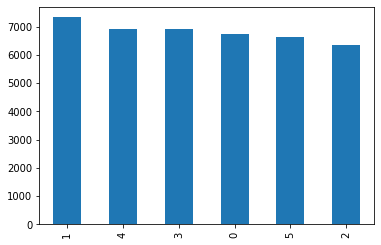

In [ ]:
# 레이블 값의 분포 시각화
plt.figure(figsize=(6, 4))
feel_bic_df['대분류_num'].value_counts().plot(kind='bar');

In [ ]:
# 18, 38, 23번 감정이 매우 많은 분포
print('가장많은 분포의 감정: ', feel_bic_dic_reverse[1])
print('감정분포 2위: ', feel_bic_dic_reverse[4])
print('감정분포 3위: ',feel_bic_dic_reverse[3])
print('감정분포 가장적은: ',feel_bic_dic_reverse[2])

# 대체적으로 600~800개의 분포를 보인다.
# 어휴 격자 저거 y축 세분화하고싶은데 어렵네..


가장많은 분포의 감정:  불안
감정분포 2위:  분노
감정분포 3위:  슬픔
감정분포 가장적은:  당황


In [ ]:
# 각 레이블이 몇개인가
print(feel_bic_df.groupby('대분류_num').size().reset_index(name='count'))   #https://www.codeit.kr/community/threads/6279

   대분류_num  count
0        0   6731
1        1   7329
2        2   6360
3        3   6915
4        4   6920
5        5   6624


### train, val 전처리 완료 및 레이블 만들기

In [20]:
# 공백제거
val_data['번호']=val_data['번호'].astype('str')
val_data =val_data.apply(lambda x: x.str.strip() , axis = 1)

In [21]:
# 확인
val_data.head(3)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,23093,청년,여성,"진로, 취업, 직장",해당없음,분노,툴툴대는,요즘 부모님과 많이 부딪혀.,어떤 일로 부딪히시나요?,난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔. 내 마음대로 하지도...,부모님과의 충돌로 힘드시겠군요.,응. 그래도 난 내가 하고 싶은 일을 위해 노력할 거야.,자신이 하고 싶은 일을 목표로 하기로 하셨군요.,NaN,NaN
1,32848,청소년,남성,가족관계,해당없음,슬픔,비통한,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,어머니께서 집을 나가셨다니 정말 슬프셨겠어요. 좀 더 자세히 얘기해주시겠어요?,엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어. 그래서 더 마음이 ...,정말 많이 답답하셨겠어요. 어떻게 하는 게 기분이 좀 풀릴까요?,일단 좀 자야겠어.,일단 휴식을 가질 생각이시군요.,NaN,NaN
2,35590,청소년,남성,학교폭력/따돌림,해당없음,불안,조심스러운,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,용기 있는 행동을 하셨네요. 마음이 어떠셨나요?,그런데 말을 하고 난 후 나도 괴롭힐까 봐 불안했어.,그랬군요. 지금 기분에서 벗어나기 위해 할 수 있는 일에는 무엇이 있을까요?,나는 옳은 일을 한 거라고 생각해. 나까지 괴롭힌다면 신고할 거야.,지금의 상황이 나의 방식으로써 잘 해결될 수 있기를 바라요.,NaN,NaN


In [ ]:
# train셋과 val셋 비교
print('총 감정_대분류의 개수 : {}'.format(len(val_data['감정_대분류'].unique())))
set(val_data['감정_대분류'].unique()) == set(train_data['감정_대분류'].unique())

총 감정_대분류의 개수 : 6


True

In [ ]:
set(val_data['감정_소분류'].unique()) == set(train_data['감정_소분류'].unique())

True

In [22]:
val_label = []
for feel in val_data['감정_소분류']:
    val_label.append(feel_dic[feel])
pd.Series(val_label)

0       52
1       32
2       24
3       11
4       28
        ..
5125    56
5126    16
5127     7
5128    22
5129    30
Length: 5130, dtype: int64

In [23]:
train_label = []
for feel in train_data['감정_소분류']:
    train_label.append(feel_dic[feel])
np.array(train_label)

array([ 0,  1,  2, ...,  5, 45,  1])

#### 대분류로 다시

In [24]:
val_label = []
for feel in val_data['감정_대분류']:
    val_label.append(feel_bic_dic[feel])
pd.Series(val_label)

0       4
1       3
2       1
3       2
4       4
       ..
5125    0
5126    1
5127    4
5128    4
5129    4
Length: 5130, dtype: int64

In [25]:
train_label = []
for feel in train_data['감정_대분류']:
    train_label.append(feel_bic_dic[feel])
np.array(train_label)

array([0, 1, 2, ..., 3, 0, 1])

## konlpy 의 Okt를 이용한 텍스트전처리

### 토큰화

In [26]:
from konlpy.tag import Okt
from konlpy.tag import Kkma
import re

In [27]:
okt=Okt()
X_train = []
for sentence in train_data['사람문장1']:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stop_words] # 불용어 제거
    X_train.append(stopwords_removed_sentence)
print(X_train[:3])

[['아내', '드디어', '출산', '하다', '되어다', '정말', '신'], ['당뇨', '랑', '합병증', '먹다', '하다', '약', '열', '넘어가다', '스트레스'], ['고등학교', '올라오다', '중학교', '보다', '수업', '갑자기', '어려워지다', '당황', '스럽다']]


In [28]:
X_test = []
for sentence in val_data['사람문장1']:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stop_words] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

### 정수인코딩

- 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다. 우선, 훈련 데이터에 대해서 단어 집합(vocaburary)을 만들어봅시다.

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [30]:
word_index = tokenizer.word_index
print(tokenizer.word_index)   # 여기서 oov는 어떻게 되는거지?

# 0은 패딩을 위해 비워둠

{'하다': 1, '너무': 2, '친구': 3, '는': 4, '도': 5, '없다': 6, '보다': 7, '않다': 8, '은': 9, '좋다': 10, '못': 11, '받다': 12, '이야': 13, '되다': 14, '만': 15, '들다': 16, '돼다': 17, '회사': 18, '오늘': 19, '요즘': 20, '돈': 21, '정말': 22, '게': 23, '나르다': 24, '아내': 25, '싶다': 26, '걱정': 27, '스럽다': 28, '한테': 29, '가다': 30, '남편': 31, '하고': 32, '힘들다': 33, '?': 34, '모르다': 35, '결혼': 36, '나다': 37, '고': 38, '슬프다': 39, '자다': 40, '화가': 41, '다': 42, '많이': 43, '직장': 44, '오다': 45, '기분': 46, '아프다': 47, '!': 48, '마음': 49, '거': 50, '아들': 51, '나오다': 52, '되어다': 53, '당황': 54, '엄마': 55, '준비': 56, '많다': 57, '불안하다': 58, '당하다': 59, '건강': 60, '나이': 61, '해': 62, '랑': 63, '먹다': 64, '병원': 65, '어떻다': 66, '자식': 67, '가족': 68, '이제': 69, '학교': 70, '취업': 71, '부모님': 72, '기쁘다': 73, '인데': 74, '일이': 75, '자꾸': 76, '난': 77, '날': 78, '주다': 79, '속상하다': 80, '딸': 81, '걸': 82, '노후': 83, '짜증': 84, '은퇴': 85, '다니다': 86, '그렇다': 87, '아무': 88, '내다': 89, '어제': 90, '아니다': 91, '공부': 92, '라고': 93, '갑자기': 94, '몸': 95, '인': 96, '아빠': 97, '만나다': 98, '알다': 99, '스트레스': 100, '싫다'

In [31]:
vocab_size = len(tokenizer.word_index) +1     # 단어집합의 크기

In [32]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [33]:
print(X_train[:3])

# 각 샘플 내의 단어들은 각 단어에 대한 정수로 변환된 것을 확인할 수 있습니다.

[[25, 193, 277, 1, 53, 22, 588], [340, 63, 1003, 64, 1, 248, 584, 1183, 100], [532, 1386, 1319, 7, 564, 94, 984, 54, 28]]


In [34]:
# 훈련 데이터와 테스트 데이터의 문장과 레이블을 각각 저장합니다.
y_train = np.array(train_label)
y_test = np.array(val_label)

### 패딩

텍스트 최대 길이 : 42
텍스트 평균 길이 : 8.9839771031581


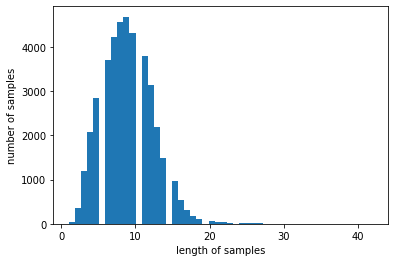

In [ ]:
print('문장의 최대 길이 :',max(len(text) for text in X_train))
print('문장의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(text) for text in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# 전체 데이터의 길이 분포는 대체적으로 약 9내외의 길이를 가지는 것을 볼 수 있습니다. 

In [35]:
# 모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있습니다. 특정 길이 변수를 max_len으로 정합니다. 대부분의 리뷰가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값은 몇일까요? 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 만듭니다.
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


In [36]:
# 위의 분포 그래프를 봤을 때, max_len = 20이 적당할 것 같습니다. 이 값이 얼마나 많은 리뷰 길이를 커버하는지 확인해봅시다. 채팅 특성상 엄청 긴 문장이 포함되지 않으므로, 최대길이로 모든 데이터를 패딩하면 됨. --> 그러나 별 차이 없었다고 한다.
max_len =  18          # 18 에서 99%
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 18 이하인 샘플의 비율: 99.24166442427652


In [37]:
# 전체 훈련 데이터 중 약 99%의 리뷰가 18이하의 길이를 가지는 것을 확인했습니다. 모든 샘플의 길이를 18으로 맞추겠습니다.
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [38]:
# 훈련용, 테스트용 뉴스 기사 데이터의 레이블에 원-핫 인코딩을 합니다.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
y_train

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
print('전체 데이터의 크기(shape):', X_train.shape)
print('레이블 데이터의 크기(shape):', y_train.shape)

전체 데이터의 크기(shape): (40879, 18)
레이블 데이터의 크기(shape): (40879, 6)


In [ ]:
print(X_train[0])
print(y_train[0])

[  0   0   0   0   0   0   0   0   0   0   0  25 193 277   1  53  22 588]
[1. 0. 0. 0. 0. 0.]


### 다층퍼셉트론으로 감성분류

In [ ]:
# 모델링은 메모리를 엄청 차지하는 sparse한 형태의 one-hot-encoding 방법이 아니라, 주변 단어들이 나타날 확률을 나타내는 word embedding 방식을 적용한 후에 수행시킨다. word embedding에 대해서는 인터넷 찾아보면 되는데, word2vec, fasttext, glove 등의 방법


from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding, Conv1D
from tensorflow.keras.layers import Dense, Dropout

embedding_dim = 100
num_classes =  6  #58


model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(Flatten())


# model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)합니다. 또한, ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다.

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, epochs=50, callbacks=[es, mc], batch_size=64, validation_split=0.2)


loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

Epoch 1/50
509/511 [============================>.] - ETA: 0s - loss: 1.3881 - acc: 0.4740
Epoch 00001: val_acc improved from -inf to 0.60091, saving model to best_model.h5
511/511 [==============================] - 13s 23ms/step - loss: 1.3871 - acc: 0.4746 - val_loss: 1.0982 - val_acc: 0.6009
Epoch 2/50
510/511 [============================>.] - ETA: 0s - loss: 0.9628 - acc: 0.6660
Epoch 00002: val_acc improved from 0.60091 to 0.61118, saving model to best_model.h5
511/511 [==============================] - 14s 27ms/step - loss: 0.9630 - acc: 0.6659 - val_loss: 1.0758 - val_acc: 0.6112
Epoch 3/50
509/511 [============================>.] - ETA: 0s - loss: 0.6957 - acc: 0.7698
Epoch 00003: val_acc did not improve from 0.61118
511/511 [==============================] - 16s 32ms/step - loss: 0.6954 - acc: 0.7699 - val_loss: 1.1706 - val_acc: 0.6018
Epoch 4/50
510/511 [============================>.] - ETA: 0s - loss: 0.4873 - acc: 0.8419
Epoch 00004: val_acc did not improve from 0.61118


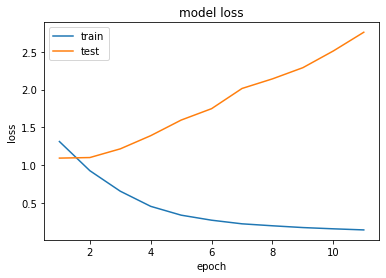

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# 예측해보기
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stop_words] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = loaded_model.predict(pad_new) # 예측
#   print(score[0, score.argmax()])
  return feel_bic_dic_reverse[score.argmax()]

In [ ]:
sentiment_predict('사랑해')

'기쁨'

### LSTM으로 감성분류

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# 임베딩 벡터의 차원은 100으로 정했고, 리뷰 분류를 위해서 은닉 상태의 크기가 128인 LSTM을 사용
embedding_dim = 100
hidden_units = 128
num_classes =  6  # 58

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)합니다. 또한, ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다.

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
history = model.fit(X_train, y_train, epochs=50, callbacks=[es, mc], batch_size=64, validation_split=0.2)

# 에포크는 총 15번을 수행하겠습니다. 또한 훈련 데이터 중 20%를 검증 데이터로 사용하면서 정확도를 확인합니다.

Epoch 1/50
511/511 [==============================] - ETA: 0s - loss: 1.2416 - acc: 0.5432
Epoch 00001: val_acc improved from -inf to 0.60665, saving model to best_model.h5
511/511 [==============================] - 44s 80ms/step - loss: 1.2416 - acc: 0.5432 - val_loss: 1.0723 - val_acc: 0.6067
Epoch 2/50
511/511 [==============================] - ETA: 0s - loss: 0.9584 - acc: 0.6552
Epoch 00002: val_acc did not improve from 0.60665
511/511 [==============================] - 42s 82ms/step - loss: 0.9584 - acc: 0.6552 - val_loss: 1.0959 - val_acc: 0.6042
Epoch 3/50
511/511 [==============================] - ETA: 0s - loss: 0.8533 - acc: 0.6969
Epoch 00003: val_acc did not improve from 0.60665
511/511 [==============================] - 38s 75ms/step - loss: 0.8533 - acc: 0.6969 - val_loss: 1.1225 - val_acc: 0.6024
Epoch 4/50
511/511 [==============================] - ETA: 0s - loss: 0.7740 - acc: 0.7237
Epoch 00004: val_acc did not improve from 0.60665
511/511 [==========================

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

161/161 [==============================] - 2s 10ms/step - loss: 1.0948 - acc: 0.6019

 테스트 정확도: 0.6019


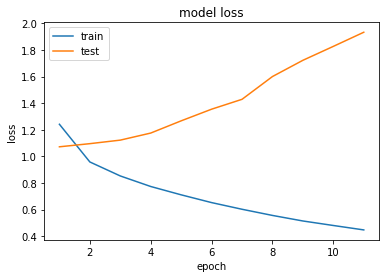

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# 예측해보기
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stop_words] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = loaded_model.predict(pad_new) # 예측
#   print(score[0, score.argmax()])
  return feel_bic_dic_reverse[score.argmax()]

In [ ]:
sentiment_predict('사랑해')

ValueError: ignored

### 사전학습된 워드임베딩을 통한 감성분류
- 사전훈련된 워드임베딩 사용하기.(스탠포드 대학교에서 제공하는 사전 훈련된 GloVe 임베딩을 사용)
- 자연어 처리 작업을 할때, 케라스의 Embedding()를 사용하여 갖고 있는 훈련 데이터로부터 처음부터 임베딩 벡터를 훈련시키기도 하지만, 위키피디아 등의 방대한 데이터로 사전에 훈련된 워드 임베딩(pre-trained word embedding vector)를 가지고 와서 해당 벡터들의 값을 원하는 작업에 사용 할 수도 있습니다.
- 예를 들어서 감성 분류 작업을 하는데 훈련 데이터의 양이 부족한 상황이라면, 다른 방대한 데이터를 Word2Vec이나 GloVe 등으로 사전에 학습시켜놓은 임베딩 벡터들을 가지고 와서 모델의 입력으로 사용하는 것이 때로는 더 좋은 성능을 얻을 수 있습니다.

< 사전훈련된 word2vec를 만든 사람>
- https://github.com/Kyubyong/wordvectors
- 소개: https://omicro03.medium.com/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC-nlp-14%EC%9D%BC%EC%B0%A8-word2vec-%EC%8B%A4%EC%8A%B52-8e518a358b6c


<페이스북에서 만든 사전훈련된 fasttext>
- 소개 : https://inahjeon.github.io/fasttext/
- 사전훈련된 fasttext를 불러올 때 gensim을 이용하는 게 잘 안돼서 : https://datascience.stackexchange.com/questions/20071/how-do-i-load-fasttext-pretrained-model-with-gensim

- 결국 https://fasttext.cc/docs/en/crawl-vectors.html 의 방법대로 직접 불러오고,

- 임베딩 벡터를 추가하는 방법은 공식문서에 이렇게 표현되지만 --> https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

- 케라스 블로그에서 fasttext의 사전훈련된 워드임베딩을 어떻게 임베딩레이어에 추가하는지 확인할 수 있다. https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

- fasttext 깃허브 : https://github.com/facebookresearch/fastText/#building-fasttext-for-python


https://github.com/naver/claf/issues/25 이건 또 뭐지.


http://doc.mindscale.kr/km/unstructured/11.html 한국어 워드투벡터 사전학습


https://fasttext.cc/docs/en/python-module.html fasttext 메서드 모음


함수 형 api https://www.codeonweb.com/entry/f0dba923-2630-49b6-9af3-ceb0b67dd70a

https://keras.io/ko/getting-started/functional-api-guide/

임베딩 모델과 통합하는 방법.https://velog.io/@jaehyeong/Multi-input-%EB%AA%A8%EB%8D%B8-%EA%B5%AC%EC%B6%95%ED%95%98%EA%B8%B0-by-Keras-Functional-API

다양한 사례 ;https://hwiyong.tistory.com/100

함수형 api의 사례에 대해서 좀 더 다양하게 보고싶다..!! 임베딩 모델을 따로 만들고 이를 합하는 방법이 있는데..? 성능좋은 임베딩 모델을 만든 다음 이걸 다양한 챗봇에 활용하고 싶다는 생각을 해보았다. 

어렵고 어지러워서 자꾸 중간중간 집중력을 잃게되지만,
하나하나 이해할 수 있는 말이 늘어갈 수록 느껴지는 희열...!

In [45]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [ ]:
# fasttext파이썬 모듈 빌드 : https://fasttext.cc/docs/en/support.html#building-fasttext-python-module

In [ ]:
# 다음으로 사전 훈련된 임베딩의 데이터 덤프를 구문 분석하여 알려진 임베딩에 대한 인덱스 매핑 단어를 계산합니다.  # fasttext의 사전 훈련된 단어 벡터의 차원은 300.
embeddings_index = {}
FASTTEXT_DIR = '/content/drive/MyDrive/프로젝트1'
f = open(os.path.join(FASTTEXT_DIR, 'cc.ko.300.txt'), encoding='utf-8', errors='ignore')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
# 이 시점에서 embedding_index사전과 우리 word_index를 활용 하여 임베딩 행렬을 계산할 수 있습니다 .
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# 트랜스포머 구현

In [ ]:
pip install sentence_transformers

     |████████████████████████████████| 78 kB 3.0 MB/s 
     |████████████████████████████████| 3.4 MB 7.0 MB/s 
     |████████████████████████████████| 3.3 MB 14.6 MB/s 
     |████████████████████████████████| 1.2 MB 24.9 MB/s 
     |████████████████████████████████| 61 kB 186 kB/s 
     |████████████████████████████████| 596 kB 34.6 MB/s 
     |████████████████████████████████| 895 kB 21.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=0146707f88b192dbb66f2c3a37f8c0ae76b0de4cff4e22c16b67c680c9253021
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# 문장 임베딩을 얻기 위해서 사전 훈련된 BERT를 로드
model = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

Downloading:   0%|          | 0.00/574 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/731 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

# 트랜스포머를 이용한 한국어 챗봇

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
import numpy as np
import pandas as pd
from numpy import dot
from numpy.linalg import norm
import urllib.request
from sentence_transformers import SentenceTransformer